In [1]:
import os
import numpy as np
from PIL import Image
import cv2
from utils import preview
from imgaug import augmenters as iaa
import datetime
import json

# Function definition

### Load object images

In [2]:
def load_images(image_dir):
    """
    Load transparent object images from a directory
    """
    # Image file paths
    image_files = os.listdir(image_dir)
    image_files.remove('.DS_Store')
    image_files = [os.path.join(image_dir, f) for f in image_files] 

    # Load images
    images = []
    for f in image_files:
        img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
        images.append(img)

    return images

### Augment object images

In [3]:
def pad_image(img, padding=10, constant=0):
    """
    Pad the outer edges of a 2D image with a constant value
    
    Arguments:
    - img - numpy array - image to pad
    - padding - int - padding to apply
    - constant - int - constant value to pad with
    
    Returns:
    - image_padded - numpy array - padded image
    """
    img = img.copy()
    img_padded = np.ones(
        (img.shape[0] + padding*2, img.shape[1] + padding*2, img.shape[2]),
        dtype=img.dtype
    ) * constant
    img_padded[padding:-padding, padding:-padding] = img
    return img_padded

In [4]:
def restore_alpha(image, crop=False):
    """
    Restores the alpha channel to 0 or 255 after image augmentation distorts it
    
    Arguments:
    - image - numpy array - image to restore the alpha channel for
    - crop - bool - whether to crop the image using the alpha channel
    
    Returns:
    - image - numpy array - image with transparent background
    """
    image = image.copy()
    
    # Binarise the alpha channel
    alpha_channel = image[:, :, 3]
    alpha_channel = (alpha_channel >= 128) * 255
    image[:, :, 3] = alpha_channel
    # Set all channels to 0 if alpha is 0 for that pixel
    alpha_zero = (alpha_channel == 0)
    image[alpha_zero] = 0

    # Crop away any parts of the image that have 0 alpha
    if crop:
        object_pixels = np.where(~alpha_zero)
        xmin, xmax = object_pixels[0].min(), object_pixels[0].max()
        ymin, ymax = object_pixels[1].min(), object_pixels[1].max()
        image = image[xmin:xmax, ymin:ymax]
        
    return image

In [5]:
def augment_images(images):
    """
    Augment transparent object images using imgaug
    """
    seq = iaa.Sequential(
        [
            # Horizontal flips
            iaa.Fliplr(0.5),
            # Small gaussian blur 
            iaa.Sometimes(
                0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.LinearContrast((0.75, 1.5)),
            # Add gaussian noise
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            # Scale/zoom and rotate
            iaa.Affine(
                scale={"x": (0.6, 1), "y": (0.6, 1)},
                rotate=(-10, 10)
            )
        ],
        random_order=True
    )
    
    # Pad images, augment and crop to bounding box using alpha channel
    images = [pad_image(img, padding=50) for img in images]
    images_aug = seq(images=images)
    images_aug = [restore_alpha(img, crop=True) for img in images_aug]
    
    return images_aug

### Load texture images

In [6]:
def load_textures(texture_dir):
    """
    Load texture images from the subdirectories of texture_dir
    """
    # Texture image file paths
    texture_folders = os.listdir(texture_dir)
    texture_folders.remove('.DS_Store')

    # Recursively get texture image file paths
    texture_files = []
    for folder in texture_folders:
        folder_files = os.listdir(os.path.join(texture_dir, folder))
        for file in folder_files:
            if file != '.directory':
                texture_files.append(os.path.join(texture_dir, folder, file))

    # Load texture images
    textures = []
    for f in texture_files:    
        img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
        textures.append(img)

    return textures

### Generate training images from object and texture images

In [7]:
def add_background(obj, bg, x, y, image_size):
    """
    Add an object to a background at position x, y
    The background will be resized to be square and a multiple of 32
    x, y and the object size will be adjusted to fit the object on the background
    
    Arguments:
    - obj - numpy array - object image to overlay on the background
    - bg - numpy array - background image
    - x - int - x coordinate for the top left of the image
    - y - int - y coordinate for the top left of the image
    
    Returns:
    - img - numpy array - object image pasted onto the background image 
    - bbox - dict - bounding box for the object
    """
    obj = obj.copy()
    bg = bg.copy()
    
    # Resize background to be a square with length equal to a multiple of 32
    bg_height, bg_width = bg.shape[0], bg.shape[1]
    bg_length = image_size # 32 * int(min(bg_height, bg_width) / 32)
    bg = bg[:bg_length, :bg_length]
    
    # Size the object so that it fits on the background
    obj_height, obj_width = obj.shape[0], obj.shape[1]
    while (obj_height >= bg_length * 0.9) or (obj_width >= bg_length * 0.9):
        obj = obj[::2, ::2]
        obj_height, obj_width = obj.shape[0], obj.shape[1]
    
    # Merge the object with the background (ensure that it fits)
    x = x % (bg_length - obj_width)
    y = y % (bg_length - obj_height)
    obj = Image.fromarray(obj)
    img = Image.fromarray(bg)
    img.paste(obj, (x, y), obj)
    # Bounding box for training
    bbox = {'xmin': x, 'xmax': x + obj_width, 'ymin': y, 'ymax': y + obj_height}
    
    return img, bbox

In [8]:
def generate_images(objects, backgrounds, sample_size, output_dir, image_size=224, data_split=(60,20,20)):
    """
    Generate images from object and background images 
    
    Arguments:
    - objects: list of object images with transparent backgrounds
    - backgrounds: list of background images
    - sample_size: number of images to generate
    """
    # Generate output folder names
    time = datetime.datetime.now().strftime('%y%m%d_%H%M%S')
    output_dir = output_dir + time
    data_dir = {
        'train': os.path.join(output_dir, 'train'),
        'val': os.path.join(output_dir, 'val'),
        'test': os.path.join(output_dir, 'test')
    }
    num_samples = {
        'train': int(sample_size * data_split[0]/100),
        'val': int(sample_size * data_split[1]/100),
        'test': int(sample_size * data_split[2]/100)
    }
    
    # Create folders
    print(f'Saving training samples to: {output_dir}')
    os.mkdir(output_dir)
    json.dump(num_samples, open(os.path.join(output_dir, 'DATA_DESCRIPTION.json'), 'w'))
    for i, dataset in enumerate(['train', 'val', 'test']):
        dataset_dir = os.path.join(output_dir, dataset)
        stickie_dir = os.path.join(dataset_dir, 'stickie')
        texture_dir = os.path.join(dataset_dir, 'texture')
        for sub_dir in [dataset_dir, stickie_dir, texture_dir]:
            os.mkdir(sub_dir)
        os.mkdir(os.path.join(stickie_dir, 'images'))
        os.mkdir(os.path.join(stickie_dir, 'bboxes'))
        os.mkdir(os.path.join(texture_dir, 'images'))

        # Generate training images
        for i in range(num_samples[dataset]):
            print(f'Generating {dataset} data ({i+1}/{num_samples[dataset]})', end='\r')
            # Random sample (don't use np.random.choice in-case all images have same dimensions)
            obj = objects[np.random.randint(0, len(objects)-1)]
            bg = backgrounds[np.random.randint(0, len(backgrounds)-1)]
            x = np.random.randint(0, bg.shape[1])
            y = np.random.randint(0, bg.shape[0])
            # Generate image
            training_image, bbox = add_background(obj, bg, x, y, image_size)

            # Save image and bounding box
            image_path = os.path.join(stickie_dir, 'images', f'stickie-{i}.png')
            bbox_path  = os.path.join(stickie_dir, 'bboxes', f'bbox-{i}.json')
            training_image.save(image_path)
            json.dump(bbox, open(bbox_path, 'w'))

            # Save texture 
            bg_path = os.path.join(texture_dir, 'images', f'texture-{i}.png')
            bg = backgrounds[np.random.randint(0, len(backgrounds)-1)].copy()[:image_size, :image_size]
            Image.fromarray(bg).save(bg_path)
        print()

# Run pipeline

Loading object images...


Augmenting object images...


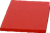

Loading texture images...


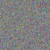

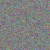

In [9]:
# Load images
print('Loading object images...')
images = load_images('../data/interim/images/')
# Preview
for image in images[:2]:
    preview(image, size=50)

# Augment images (twice, then append the original images)
print('Augmenting object images...')
images_aug = augment_images(images)
images_aug.extend(augment_images(images))
images_aug.extend(images)
# Preview
for image in images_aug[:2]:
    preview(image, size=50)

# Load textures
print('Loading texture images...')
#    textures = load_textures('../data/raw/dtd/images/')
textures = [np.array((np.random.random((224,224,3)) * 255), dtype='uint8') for _ in range(100)]
# Preview
for texture in textures[:2]:
    preview(texture, size=50)

In [11]:
sample_size = 10000
# Generate images
print('Generating images...')
generate_images(images_aug, textures, sample_size, output_dir='../data/processed/',
                data_split=(90, 5, 5), image_size=224)
print('Done')

Generating images...
Saving training samples to: ../data/processed/200428_095708
Generating train data (9000/9000)
Generating val data (500/500)
Generating test data (500/500)
Done
